<a href="https://colab.research.google.com/github/Saketh2611/Diabetes-Predictor/blob/main/Diabetes_predictor_Using_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Dataset of Diabetes .csv to Dataset of Diabetes .csv


# 📦 IMPORT REQUIRED LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 📥 Load the dataset

In [ ]:

data = pd.read_csv("Dataset of Diabetes .csv")
data['CLASS'] = data['CLASS'].str.strip()


# 🧹 Clean & preprocess

In [ ]:

data = data[data['CLASS'].isin(['N', 'Y'])]  # Drop 'P' class if exists
data['Gender'] = data['Gender'].map({'F': 0, 'M': 1})
data = data.drop(['ID', 'No_Pation'], axis=1)  # Drop identifiers

/tmp/ipython-input-4-2964637715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Gender'] = data['Gender'].map({'F': 0, 'M': 1})


# LABEL ENCODING CLASSES

In [ ]:
y = LabelEncoder().fit_transform(data['CLASS'])  # 'N' -> 0, 'Y' -> 1
X = data.drop(['CLASS'], axis=1)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🧪 Check and clean invalid values

In [ ]:
print("Any NaNs in scaled input?", np.isnan(X_scaled).any())
print("Any Infs in scaled input?", np.isinf(X_scaled).any())
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

Any NaNs in scaled input? True
Any Infs in scaled input? False


# 🔁 Convert to tensors

In [ ]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# 🧠 AE Architecture

In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=4):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat  # ✅ Correct return


# ⚙️ Training AE

In [ ]:
input_dim = X_tensor.shape[1]
ae = Autoencoder(input_dim)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Trained for 300 epochs to get less loss

In [ ]:
for epoch in range(300):
    total_loss = 0
    for batch_x, _ in dataloader:
        optimizer.zero_grad()
        x_hat = ae(batch_x)
        loss = criterion(x_hat, batch_x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1, Loss: 0.0983
Epoch 2, Loss: 0.0985
Epoch 3, Loss: 0.0984
Epoch 4, Loss: 0.0972
Epoch 5, Loss: 0.0969
Epoch 6, Loss: 0.0981
Epoch 7, Loss: 0.0989
Epoch 8, Loss: 0.0987
Epoch 9, Loss: 0.1010
Epoch 10, Loss: 0.0985
Epoch 11, Loss: 0.1044
Epoch 12, Loss: 0.0995
Epoch 13, Loss: 0.1009
Epoch 14, Loss: 0.0999
Epoch 15, Loss: 0.0966
Epoch 16, Loss: 0.0946
Epoch 17, Loss: 0.0956
Epoch 18, Loss: 0.0950
Epoch 19, Loss: 0.0990
Epoch 20, Loss: 0.0976
Epoch 21, Loss: 0.0958
Epoch 22, Loss: 0.0954
Epoch 23, Loss: 0.0948
Epoch 24, Loss: 0.0943
Epoch 25, Loss: 0.0946
Epoch 26, Loss: 0.0957
Epoch 27, Loss: 0.0963
Epoch 28, Loss: 0.0959
Epoch 29, Loss: 0.0947
Epoch 30, Loss: 0.0936
Epoch 31, Loss: 0.0951
Epoch 32, Loss: 0.0934
Epoch 33, Loss: 0.0927
Epoch 34, Loss: 0.0927
Epoch 35, Loss: 0.0935
Epoch 36, Loss: 0.0947
Epoch 37, Loss: 0.0925
Epoch 38, Loss: 0.0934
Epoch 39, Loss: 0.0932
Epoch 40, Loss: 0.0920
Epoch 41, Loss: 0.0920
Epoch 42, Loss: 0.0919
Epoch 43, Loss: 0.0913
Epoch 44, Loss: 0.09

# 🔍 Extract Latent Features

In [ ]:
with torch.no_grad():
    latent_features = ae.encoder(X_tensor).numpy()

# Splitting Train and Test data

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(latent_features, y, test_size=0.2, random_state=42)

# 🧪 RFC Pipeline with GridSearchCV

In [ ]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__n_estimators': [100, 200, 300, 400, 500],
    'clf__max_depth': [None, 10, 20, 30, 40, 50],
    'clf__min_samples_split': [2,3,4, 5],
    'clf__class_weight': ['balanced']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_macro',  # better if classes are imbalanced
    n_jobs=-1,
    verbose=2
)

print("\n🔍 Running GridSearchCV on AE latent features...")



🔍 Running GridSearchCV on AE latent features...


In [ ]:
# Fit on latent features
grid_search.fit(xTrain, yTrain)

# Best parameters
print("\n🏆 Best Parameters Found:")
print(grid_search.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits

🏆 Best Parameters Found:
{'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [ ]:
best_model = grid_search.best_estimator_
yPred = best_model.predict(xTest)

In [ ]:
print("\n✅ Evaluation on AE latent features:")
print("Accuracy:", accuracy_score(yTest, yPred))
print("Classification Report:\n", classification_report(yTest, yPred))


✅ Evaluation on AE latent features:
Accuracy: 0.9842105263157894
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.98      1.00      0.99       170

    accuracy                           0.98       190
   macro avg       0.99      0.93      0.96       190
weighted avg       0.98      0.98      0.98       190



In [ ]:
y_pred_1 = pipeline.fit(xTrain, yTrain).predict(xTest)

print("\n✅ Evaluation on AE latent features:")
print("Accuracy:", accuracy_score(yTest, y_pred_1))
print("Classification Report:\n", classification_report(yTest, y_pred_1))


✅ Evaluation on AE latent features:
Accuracy: 0.9789473684210527
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.98      0.99      0.99       170

    accuracy                           0.98       190
   macro avg       0.96      0.92      0.94       190
weighted avg       0.98      0.98      0.98       190



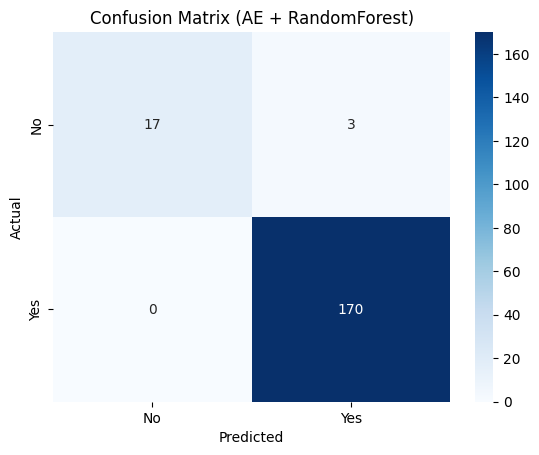

In [ ]:
# 📉 Confusion Matrix
conf_matrix = confusion_matrix(yTest, yPred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (AE + RandomForest)')
plt.show()

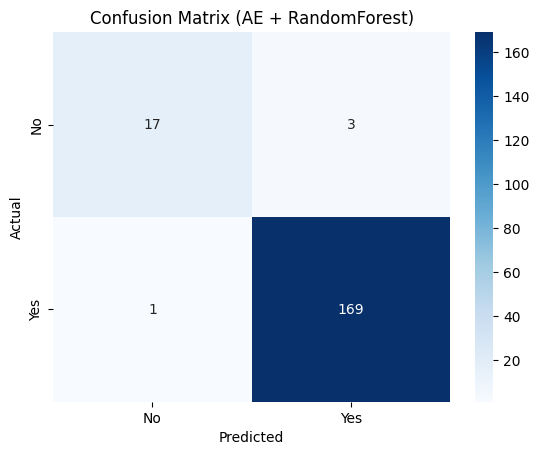

In [ ]:
# 📉 Confusion Matrix
conf_matrix = confusion_matrix(yTest, y_pred_1)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (AE + RandomForest)')
plt.show()


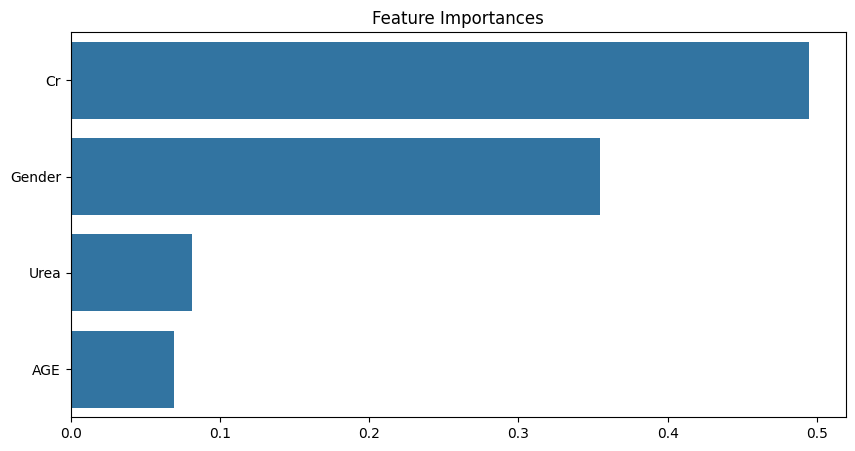

In [ ]:
importances_1 = best_model.named_steps['clf'].feature_importances_
feature_names_1 = X.columns  # Original feature names
sorted_idx = np.argsort(importances_1)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances_1[sorted_idx], y=np.array(feature_names_1)[sorted_idx])
plt.title("Feature Importances")
plt.show()